In [36]:
import os
import pandas as pd
import numpy as np
import keras

os.chdir('C:/Users/HK/Desktop/GitHub/Deep-Learning/NLP')

In [37]:
lines = pd.read_table('datasets/kor.txt', names = ['source', 'target'])
lines.target = lines.target.apply(lambda x : '<sos> ' + x + ' <eos>')

In [38]:
lines.head()

,source,target
0,Who?,<sos> 누구? <eos>
1,Hello!,<sos> 안녕! <eos>
2,No way!,<sos> 절대 아니야. <eos>
3,No way!,<sos> 그럴리가! <eos>
4,Goodbye!,<sos> 안녕! <eos>


In [39]:
from keras.preprocessing.text import Tokenizer

In [40]:
source_t = Tokenizer()
source_t.fit_on_texts(lines.source)
source_vocab_size = len(source_t.word_index) + 1

target_t = Tokenizer()
target_t.fit_on_texts(lines.target)
target_vocab_size = len(target_t.word_index) + 1

In [41]:
print(source_vocab_size)
print(target_vocab_size)

1170
2049


In [42]:
encoder_input_data = source_t.texts_to_sequences(lines.source)
source_max_length = max(len(l) for l in encoder_input_data)

decoder_input_data = target_t.texts_to_sequences(lines.target)
decoder_target_data = [l[1:] for l in decoder_input_data]
target_max_length = max(len(l) for l in decoder_input_data)

In [43]:
print(source_max_length)
print(target_max_length)

19
17


In [44]:
from keras.preprocessing.sequence import pad_sequences

In [45]:
encoder_input_data = pad_sequences(
    encoder_input_data, maxlen = source_max_length, padding = 'post')
decoder_input_data = pad_sequences(
    decoder_input_data, maxlen = target_max_length, padding = 'post')
decoder_target_data = pad_sequences(
    decoder_target_data, maxlen = target_max_length, padding = 'post')

In [46]:
from keras.utils import to_categorical

In [47]:
decoder_target_data = to_categorical(decoder_target_data)

In [48]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(909, 19)
(909, 17)
(909, 17, 2049)


In [49]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, save_model, load_model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K

In [50]:
rnn_units = 64
embedding_size = 200

K.clear_session()

# 인코더 설계

encoder_inputs = Input(shape = (None,))
encoder_embedding_layer = Embedding(source_vocab_size, embedding_size)
encoder_embedding = encoder_embedding_layer(encoder_inputs)

# 인코더 LSTM
encoder_lstm = LSTM(units = rnn_units, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# 디코더 설계

decoder_inputs = Input(shape = (None,))
decoder_embedding_layer = Embedding(target_vocab_size, embedding_size)
decoder_embedding = decoder_embedding_layer(decoder_inputs)

# 디코더 LSTM
decoder_lstm = LSTM(units = rnn_units, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state = encoder_states)
decoder_softmax_layer = Dense(target_vocab_size, activation = 'softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [51]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer = optimizers.rmsprop(),
              loss = "categorical_crossentropy",
              metrics = ['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    234000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 200)    409800      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [52]:
epochs = 300
batch_size = 128

modelpath = 'models/word-level-seq2seq-eng-to-kor.hdf5'
check = ModelCheckpoint(modelpath, monitor = 'val_acc', save_best_only = True, save_weights_only = True)
early = EarlyStopping(monitor = 'val_acc', patience = 50)

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    validation_split = 0.2,
                    callbacks = [check, early],
                    epochs = epochs, batch_size = batch_size, verbose = 2)

Train on 727 samples, validate on 182 samples
Epoch 1/300
 - 4s - loss: 7.4620 - acc: 0.6009 - val_loss: 6.7572 - val_acc: 0.5692
Epoch 2/300
 - 2s - loss: 5.7586 - acc: 0.7315 - val_loss: 5.4238 - val_acc: 0.5692
Epoch 3/300
 - 2s - loss: 4.3063 - acc: 0.7315 - val_loss: 4.4634 - val_acc: 0.5692
Epoch 4/300
 - 2s - loss: 3.3088 - acc: 0.7315 - val_loss: 3.9726 - val_acc: 0.5692
Epoch 5/300
 - 2s - loss: 2.7777 - acc: 0.7315 - val_loss: 3.7066 - val_acc: 0.5692
Epoch 6/300
 - 2s - loss: 2.4567 - acc: 0.7315 - val_loss: 3.5370 - val_acc: 0.5692
Epoch 7/300
 - 2s - loss: 2.2397 - acc: 0.7315 - val_loss: 3.4204 - val_acc: 0.5692
Epoch 8/300
 - 2s - loss: 2.0921 - acc: 0.7315 - val_loss: 3.3992 - val_acc: 0.5692
Epoch 9/300
 - 2s - loss: 1.9843 - acc: 0.7315 - val_loss: 3.3928 - val_acc: 0.5692
Epoch 10/300
 - 2s - loss: 1.9053 - acc: 0.7315 - val_loss: 3.2543 - val_acc: 0.5692
Epoch 11/300
 - 2s - loss: 1.8429 - acc: 0.7315 - val_loss: 3.2770 - val_acc: 0.5692
Epoch 12/300
 - 2s - loss: 1

Epoch 97/300
 - 5s - loss: 0.9682 - acc: 0.8130 - val_loss: 4.2933 - val_acc: 0.6364
Epoch 98/300
 - 5s - loss: 0.9554 - acc: 0.8151 - val_loss: 4.2960 - val_acc: 0.6364
Epoch 99/300
 - 6s - loss: 0.9492 - acc: 0.8158 - val_loss: 4.2994 - val_acc: 0.6364
Epoch 100/300
 - 6s - loss: 0.9490 - acc: 0.8150 - val_loss: 4.3070 - val_acc: 0.6357
Epoch 101/300
 - 7s - loss: 0.9422 - acc: 0.8178 - val_loss: 4.3084 - val_acc: 0.6351
Epoch 102/300
 - 7s - loss: 0.9348 - acc: 0.8174 - val_loss: 4.3139 - val_acc: 0.6354
Epoch 103/300
 - 7s - loss: 0.9338 - acc: 0.8178 - val_loss: 4.3219 - val_acc: 0.6357
Epoch 104/300
 - 8s - loss: 0.9256 - acc: 0.8192 - val_loss: 4.3234 - val_acc: 0.6351
Epoch 105/300
 - 9s - loss: 0.9179 - acc: 0.8190 - val_loss: 4.3361 - val_acc: 0.6345
Epoch 106/300
 - 8s - loss: 0.9180 - acc: 0.8200 - val_loss: 4.3417 - val_acc: 0.6348
Epoch 107/300
 - 6s - loss: 0.9087 - acc: 0.8211 - val_loss: 4.3456 - val_acc: 0.6354
Epoch 108/300
 - 5s - loss: 0.9032 - acc: 0.8217 - val_lo

In [53]:
# history = pd.read_csv('word-level-eng-kor-history.csv')

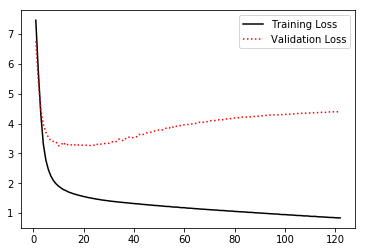

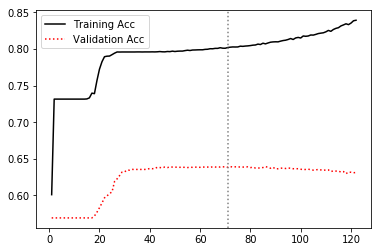

epoch 71: Training Acc = 80.25%, Validation Acc = 63.93%


In [54]:
import matplotlib.pyplot as plt

def history_plot(history):
    epoch = range(1, len(history.history['loss']) + 1)
    m = np.argmax(history.history['val_acc'])
    plt.plot(epoch, history.history['loss'], '-k', label = 'Training Loss')
    plt.plot(epoch, history.history['val_loss'], ':r', label = 'Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(epoch, history.history['acc'], '-k', label = 'Training Acc')
    plt.plot(epoch, history.history['val_acc'], ':r', label = 'Validation Acc')
    plt.axvline(m, linestyle = ':', color = 'gray')
    plt.legend()
    plt.show()
    
    print('epoch {}: Training Acc = {}%, Validation Acc = {}%'.
          format(m, np.round(history.history['acc'][m], 4)*100, np.round(history.history['val_acc'][m], 4)*100))
    
history_plot(history)

In [55]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape = (rnn_units,))
decoder_state_input_c = Input(shape = (rnn_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_p = decoder_embedding_layer(decoder_inputs)
decoder_outputs_p, state_h_p, state_c_p = decoder_lstm(
    decoder_embedding_p, initial_state = decoder_states_inputs)

decoder_states_p = [state_h_p, state_c_p]
decoder_outputs_p = decoder_softmax_layer(decoder_outputs_p)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, 
                      [decoder_outputs_p] + decoder_states_p)

In [56]:
index_to_source = dict((i, char) for char, i in source_t.word_index.items())
index_to_target = dict((i, char) for char, i in target_t.word_index.items())

In [57]:
def decode_sentence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)
    # 문장 시작에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_t.word_index['sos']
    
    stop_condition = False
    decoded_sentence = ''
    
    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition: 
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_target[sampled_token_index]
        decoded_sentence += ' ' + sampled_char
        
        # 문장 끝에 도달하거나 최대 길이를 넘으면 중단
        if (sampled_char == 'eos' or
           len(decoded_sentence) > target_max_length):
            stop_condition = True
        
        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        # 상태를 업데이트
        states_value = [h, c]
        
    return decoded_sentence

In [33]:
for i in np.random.randint(0, len(lines) - 1, size = 3):
    input_seq = encoder_input_data[i: i + 1]
    decoded_sentence = decode_sentence(input_seq)
    
    print('영어 문장:', lines.source[i])
    print('한국어 문장:', lines.target[i][5:])
    print('번역기:', decoded_sentence)
    print('-' * 50)

영어 문장: This bike isn't safe to ride; the wheel wobbles too much.
한국어 문장:  이 바이크는 별로 안전하지 않아. 바퀴가 너무 흔들려. <eos>
번역기:  나는 그것을 날씨를 싫어한다 eos
--------------------------------------------------
영어 문장: Everybody loves her.
한국어 문장:  모두 그녀를 사랑한다. <eos>
번역기:  그녀의 신앙심은 사랑한다 eos
--------------------------------------------------
영어 문장: I made reservations.
한국어 문장:  예약해 뒀어요. <eos>
번역기:  빨리 좋아해 eos
--------------------------------------------------
